### Parameters versus hyperparameters

<img src=figures/ML_parameters.png>

## ML pipeline for Text

[walter.daelemans@uantwerpen.be](mailto:walter.daelemans@uantwerpen.be)


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn

print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'sklearn: {sklearn.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
import sys
print(f'Python: {sys.version}')
!which python    

pandas: 2.1.4
numpy: 1.26.2
sklearn: 1.2.2
matplotlib: 3.8.0
Python: 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
/Users/walter/anaconda3/bin/python


In [4]:
# preprocessing and pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import make_pipeline, Pipeline

# model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# ML algorithms
from sklearn.linear_model import SGDClassifier

# evaluation
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

### Working with Text data

Language is *unstructured data* which means that we have to transform it somehow into numbers before we can do Machine Learning. This is called *vectorization*.

#### CountVectorizer

https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

The CountVectorizer creates a document representation with values that are based on term frequency (how many times does a token occur in a document), it creates a count matrix (rows are documents, columns are token frequencies of words in that document).

The reasoning here is that tokens that are frequent in a document are more important than those that are less frequent of absent.

#### TfidfVectorizer

TfidfVectorizer creates a document representation with values that are based on term frequency (how many times does a token occur in a document) multiplied by the inverse of document frequency (in how many documents does the token occur).

The reasoning behind this is to give lower weight to tokens that occur in many documents and that are therefore less informative than yokens that occur in only few documents. 

In sklearn, the formula that is used to compute the tf-idf for a token t of a document d in a document set is `tf(t, d) * idf(t)`, and the idf is computed as `log(n / df(t)) + 1`, where n is the total number of documents in the document set and `df(t)` is the document frequency of t: the number of documents in the document set that contain the term t. Adding 1 to the idf makes sure that terms with zero idf, i.e., terms that occur in all documents in a training set, will not be entirely ignored. 

https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [12]:
vect1 = CountVectorizer()
vect2 = TfidfVectorizer()

In [13]:
vect1.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [14]:
vect2.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

#### Some important parameters of the vectorizers

- 'analyzer': 'word'
    - This can also be 'char' or 'char_wb' for characters or characters within word boundaries
- 'ngram_range': (1, 1)
    - Lower and upper bound of n-grams. The default means unigrams only (from 1 to 1), (2, 2) would mean only bigrams, (1, 2) would be unigrams and bigrams, etc.
- 'binary': False
    - In case of True, it creates binary vectors
- 'lowercase': True
    - Default lowercases all words
- 'max_df': 1.0
- 'min_df': 1
    - These are the document frequency restrictions you can impose: max_df = 1.0 means a feature (e.g. a token or token bigram) can occur in all (100%) of texts; min_df = 1 means a feature should occur in at least 1 text.
- 'max_features': None
    - Use this to limit the number of features 
- 'stop_words': None
    - Use this to add a stopword list
- 'token_pattern': '(?u)\\b\\w\\w+\\b'
    - This is the Python regular expression used to define a token: a string of word characters of at least size 2 surrounded by boundary characters
- 'tokenizer': None
    - You can add your own tokenizer to replace the token_pattern


In [16]:
toy_data = ['Trump won the elections.', 'I, Harris, lost the elections!', 
            'The elections should be reliable elections.', 'Elections can be won, can be reliable!']

In [17]:
# The .fit method allows you to learn the vocabulary of the training data 
vect1.fit(toy_data)

CountVectorizer()

In [18]:
vect1.get_feature_names_out()
# This is the 'dictionary' of the vectorizer

array(['be', 'can', 'elections', 'harris', 'lost', 'reliable', 'should',
       'the', 'trump', 'won'], dtype=object)

In [19]:
# The .transform method converts texts into a numeric count representation, one word per column
toy_data_num = vect1.transform(toy_data)

In [20]:
toy_data_num

<4x10 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in Compressed Sparse Row format>

Sparse matrices contain a lot of zeroes. To make the representation more efficient, sklearn uses sparse vectors (see numpy), where for only the non-zero entries in a vector the position + the value at that position is represented). The other values are assumed to be 0.

In [22]:
print(toy_data_num)

  (0, 2)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 7)	1
  (2, 0)	1
  (2, 2)	2
  (2, 5)	1
  (2, 6)	1
  (2, 7)	1
  (3, 0)	2
  (3, 1)	2
  (3, 2)	1
  (3, 5)	1
  (3, 9)	1


In [23]:
# 4 texts, 10 features (word tokens in this case)
toy_data_num.shape

(4, 10)

In [24]:
toy_data_num.todense()

matrix([[0, 0, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 2, 0, 0, 1, 1, 1, 0, 0],
        [2, 2, 1, 0, 0, 1, 0, 0, 0, 1]])

In [25]:
# Let's put them in a dataframe
pd.DataFrame(toy_data_num.todense(), columns=vect1.get_feature_names_out())

,be,can,elections,harris,lost,reliable,should,the,trump,won
0,0,0,1,0,0,0,0,1,1,1
1,0,0,1,1,1,0,0,1,0,0
2,1,0,2,0,0,1,1,1,0,0
3,2,2,1,0,0,1,0,0,0,1


In [26]:
toy_test = ['Harris and Trump fought the elections']
toy_test_num = vect1.transform(toy_test)

In [27]:
pd.DataFrame(toy_test_num.todense(), columns=vect1.get_feature_names_out())

,be,can,elections,harris,lost,reliable,should,the,trump,won
0,0,0,1,1,0,0,0,1,1,0


In summary:

- Use .fit(train) to learn the vocabulary (features) of the training data
- Use .transform(train) to create numeric matrix from the training data, texts (rows) by features (columns) matrix
- Use .transform(test) to build a matrix from the test data I
    - Ignores features (word tokens) it hasn't seen before!

In [29]:
# same process of vect2 (tf-idf)

vect2.fit(toy_data)
toy_data_tfidf = vect2.transform(toy_data)
pd.DataFrame(toy_data_tfidf.todense(), columns=vect2.get_feature_names_out())

,be,can,elections,harris,lost,reliable,should,the,trump,won
0,0.000000,0.000000,0.343993,0.000000,0.000000,0.000000,0.000000,0.420753,0.659191,0.519714
1,0.000000,0.000000,0.318782,0.610878,0.610878,0.000000,0.000000,0.389916,0.000000,0.000000
2,0.407685,0.000000,0.539685,0.000000,0.000000,0.407685,0.517097,0.330056,0.000000,0.000000
3,0.557426,0.707024,0.184477,0.000000,0.000000,0.278713,0.000000,0.000000,0.000000,0.278713


### Text Categorization Pipeline

#### Data Preparation

In [32]:
# TOEFL Native Language Identification
# (English L2 text of people with different L1, identify L1 by analyzing L2)

# Please note that you can only use this data in the context of this MA, 
# it is not publicly available and you will have to remove it after you leave the MA

nli_train = pd.read_csv('data/TOEFL-train.csv')
nli_test = pd.read_csv('data/TOEFL-test.csv')

The TOEFL NLI dataset is based on responses to the English proficiency test for **non-native** speakers. It contains essays written in English by people with a variety of native language backgrounds. In a ML context it was used to investigate whether ML algorithms can find patterns that allow it to predict the native language of the writer.

In [34]:
nli_train.sample(5)

,id,essay,label
8242,6551,Most people are afraid to take risks or learn ...,KOR
7473,10324,I agree the idea that successful people try ne...,JPN
8497,9846,Young people can enjoy life more than older pe...,KOR
2819,7556,"In my point of view , old peolpe are more happ...",FRE
8378,8287,I agree with this statement .\nbecause I think...,KOR


In [35]:
nli_train.essay[10], nli_train.label[10]

("I agree , I belive in a saying that states `` High risk equals high returns '' .\nFrom eralier courses i have taken in school i learned that one should place their eggs in different baskets , which means that investments should be invested in different new ideas instead of concentrating on one sort of new business or idea .\n\nOne can never grow and develope if they keep on preforming what they already know how to do well , inorder for somone to grow and develope they must try new things , take chances , and make mistakes .\nFor example , when a baby first learns how to crawl and becomes very good at it , the baby is never gana crawl for the rest of his life so the baby will take the risk of walking , even tough the baby will fall several times , the baby will try again and again that 's where not being afraid to make mistakes comes in .\nThe baby can not run unless it can walk , this point emphasises the imnportance of taking risks to achive great success .\n\nThere are a lot of exa

In [36]:
nli_train.label.value_counts()

label
ARA    1100
CHI    1100
FRE    1100
GER    1100
HIN    1100
ITA    1100
JPN    1100
KOR    1100
SPA    1100
TEL    1100
TUR    1100
Name: count, dtype: int64

In [37]:
nli_test.label.value_counts()

label
ARA    100
CHI    100
FRE    100
GER    100
HIN    100
ITA    100
JPN    100
KOR    100
SPA    100
TEL    100
TUR    100
Name: count, dtype: int64

In [38]:
nli_train.duplicated().sum()

0

In [39]:
nli_train.isnull().sum()

id       0
essay    0
label    0
dtype: int64

In [40]:
X_train = nli_train.essay
y_train = nli_train.label
X_test = nli_test.essay
y_test = nli_test.label
X_train.shape, y_train.shape, X_test.shape, y_test.shape
# As usual, we will keep X_test and y_test under lock and key until the end

((12100,), (12100,), (1100,), (1100,))

#### Text Annotation with analysis tools

**We will return to this in the Natural Language Processing course of the second semester.**

A lot of NLP research will use ML methods and pipelines, but will include a stage of enriching the data with different layers of linguistic information, typically at least tokenization, lemmatization, part of speech tagging, syntactic structures, word senses (embeddings), named entities, ...

If you already want to check out NLP tools, take a look at

- Pattern3 https://github.com/clips/pattern
- Grasp https://github.com/textgain/grasp
- Spacy https://spacy.io/
- Stanza https://stanfordnlp.github.io/stanza/index.html
- NLTK https://www.nltk.org/

When new annotation layers are defined and applied to text, this involves setting up annotation guidelines, training annotators (mostly students or crowd-sourced). It is important then to measure annotation agreement with e.g., the kappa score.

Increasingly, Large Language Models are used to add these extra annotation layers or to create new training and test data (synthetic data).

Some crowdsourcing platforms

- Appen (used to be Crowdflower) https://appen.com/
- Amazon Mechanical Turk https://www.mturk.com/

#### Pipeline

In [43]:
vect = CountVectorizer(max_features=10000)
scaler = MaxAbsScaler()
clf = SGDClassifier(random_state=42)

pipe = make_pipeline(vect, scaler, clf)
# when adding additional features apart from the vectorized text, use column transformer!


The MaxAbsScaler() is a feature scaling method 
that scales the values of each feature to the range [-1, 1] (or [0, 1] when all values are positive) by dividing them by the maximum absolute value of that feature. 
It preserves sparsity, making it efficient for data represented in sparse matrices (like here) because it does not convert to dense.

The SGDClassifier in is a linear classifier that uses Stochastic Gradient Descent (SGD) for optimization of the cost function. It works well with datasets with a large number of samples and features.

It supports linear classifiers such as:
- Logistic Regression (for binary and multi-class classification)
- Support Vector Machines (SVM) (linear SVM with hinge loss)
- Perceptron

by specifying different loss functions:

- hinge: Linear SVM loss (maximum-margin classifier)
- log_loss: Logistic regression loss
- modified_huber: Robust loss function combining Huber loss with log loss
- perceptron: Perceptron loss

and also supports L1, L2, and ElasticNet regularization.

L1, L2, and Elastic Net are different regularization techniques to prevent overfitting by making the loss function more complex.

- L1 (Lasso Regularization): great for feature selection (some coefficients can become 0), use this when there are many features only some of which are relevant. 
- L2 Regularization (Ridge Regularization): when many features contribute to the solution but each only a little (small weights). 
- Elastic Net Regularization: combines L1 and L2

In [47]:
pipe.named_steps

{'countvectorizer': CountVectorizer(max_features=10000),
 'maxabsscaler': MaxAbsScaler(),
 'sgdclassifier': SGDClassifier(random_state=42)}

In [48]:
params = [{
    'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'],
    'sgdclassifier__loss': ['hinge', 'log_loss', 'perceptron', 'modified_huber']
    }]

In [49]:
gs = GridSearchCV(pipe, params, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/walter/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=10000)),
                                       ('maxabsscaler', MaxAbsScaler()),
                                       ('sgdclassifier',
                                        SGDClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'countvectorizer__ngram_range': [(1, 1), (1, 2)],
                          'sgdclassifier__loss': ['hinge', 'log_loss',
                                                  'perceptron',
                                                  'modified_huber'],
                          'sgdclassifier__penalty': ['l2', 'l1',
                                                     'elasticnet']}],
             scoring='f1_macro', verbose=1)

In [50]:
gs.best_score_

0.7409866729896896

In [51]:
gs.best_params_

{'countvectorizer__ngram_range': (1, 2),
 'sgdclassifier__loss': 'log_loss',
 'sgdclassifier__penalty': 'l2'}

In [52]:
y_test_pred = gs.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         ARA       0.77      0.75      0.76       100
         CHI       0.79      0.87      0.83       100
         FRE       0.78      0.82      0.80       100
         GER       0.85      0.86      0.86       100
         HIN       0.72      0.73      0.73       100
         ITA       0.84      0.76      0.80       100
         JPN       0.76      0.88      0.81       100
         KOR       0.84      0.70      0.77       100
         SPA       0.71      0.80      0.75       100
         TEL       0.75      0.73      0.74       100
         TUR       0.82      0.71      0.76       100

    accuracy                           0.78      1100
   macro avg       0.79      0.78      0.78      1100
weighted avg       0.79      0.78      0.78      1100



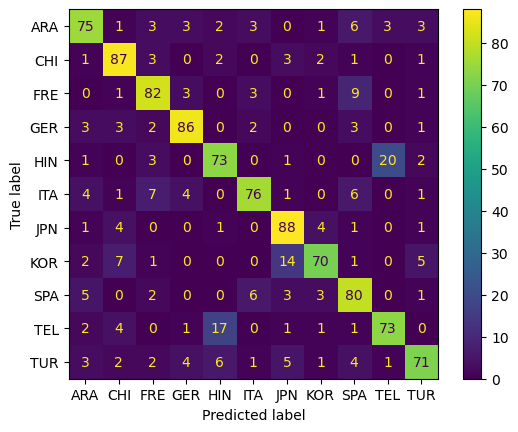

In [53]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred);

In [54]:
rs = RandomizedSearchCV(pipe, params, n_iter=12, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1, random_state=42)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(max_features=10000)),
                                             ('maxabsscaler', MaxAbsScaler()),
                                             ('sgdclassifier',
                                              SGDClassifier(random_state=42))]),
                   n_iter=12, n_jobs=-1,
                   param_distributions=[{'countvectorizer__ngram_range': [(1,
                                                                           1),
                                                                          (1,
                                                                           2)],
                                         'sgdclassifier__loss': ['hinge',
                                                                 'log_loss',
                                                                 'perceptron',
                                                                 'modified_huber'],
                                         'sgdclassifier__penalty': ['l2', 'l1',
                                                                    'elasticnet']}],
                   random_state=42, scoring='f1_macro', verbose=1)

In [55]:
rs.best_score_

0.717357034186748

In [56]:
rs.best_params_

{'sgdclassifier__penalty': 'elasticnet',
 'sgdclassifier__loss': 'log_loss',
 'countvectorizer__ngram_range': (1, 1)}

In [57]:
y_test_pred = rs.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         ARA       0.80      0.71      0.75       100
         CHI       0.73      0.88      0.80       100
         FRE       0.79      0.81      0.80       100
         GER       0.81      0.79      0.80       100
         HIN       0.60      0.68      0.64       100
         ITA       0.80      0.70      0.75       100
         JPN       0.75      0.79      0.77       100
         KOR       0.77      0.72      0.74       100
         SPA       0.76      0.79      0.77       100
         TEL       0.68      0.67      0.68       100
         TUR       0.79      0.70      0.74       100

    accuracy                           0.75      1100
   macro avg       0.75      0.75      0.75      1100
weighted avg       0.75      0.75      0.75      1100



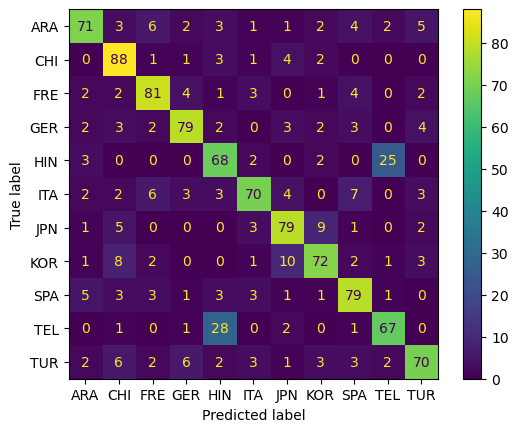

In [58]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred);